# Mini-project 1: Tic-Tac-Toe
Clément DAUVILLIERS - Florian VINCENT

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from math import log
from copy import deepcopy
from queue import deque
from random import sample
from tic_env import TictactoeEnv, OptimalPlayer

## Useful functions

In [3]:
def windowed_avg(arr, window_len=250):
    """
    Computes the average over successive windows of an array.
    arr must be a 1D array whose length is a multiple of the
    window length.
    """
    return arr.reshape((window_len, -1)).mean(axis=0)

## Player class
The following class will be used as base for the QLearning and DQN player classes.

In [4]:
class Player:
    """
    Base class for both types of players (QLearning, DQN).
    """
    def __init__(self, player='X', epsilon=0.05, seed=666):
        self.player = player
        self.epsilon = epsilon
        
        # RNG for the epsilon-gredy policy
        self.rng_ = np.random.default_rng(seed=seed)
    
    def act(self, grid):
        """
        Selects an action to perform based on the current
        grid state and the player's policy.
        """
        raise NotImplementedError("Call from abstract class")
        
    def set_player(self, player):
        self.player = player
    
    @staticmethod
    def empty(grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail
        
    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)

        return avail[self.rng_.integers(0, len(avail))]

# 2. Q-Learning

### QLPlayer class
The following class implements the QLearning player.

In [19]:
class QLPlayer(Player):
    """
    Implements a player that learns using the QLearning algorithm.
    """
    def __init__(self, player='X', lr=0.05, discount=0.99, epsilon=0.05, seed=666):
        super().__init__(player, epsilon, seed)
        self.lr = lr
        self.discount = discount
        self.epsilon = epsilon
        
        # Q-values grid
        # 3^9 = 19683 states and 9 actions
        self.qvalues = np.zeros((19683, 9))
        
        # Memory
        self.last_action = None
        self.last_state = None
        
    def act(self, grid):
        # Inverts the grid if required
        grid = self.invert_grid(grid)
        
        # Epsilon-greedy choice
        if self.rng_.random() < self.epsilon:
            return self.randomMove(grid)
        # Retrieves the list of possible actions and converts them
        # from cell positions to integer indexes
        avail_actions = QLPlayer.positions_to_ints(Player.empty(grid))
        # Ranks ALL actions according to their Qvalues in the current
        # state
        state = QLPlayer.state_to_int(grid)
        actions_ranks = np.argsort(self.qvalues[state])[::-1]
        # Browses all actions in order of their qvalue rank, until
        # finding one that is available
        for action in actions_ranks:
            if action in avail_actions:
                # Memorizes the action and the current state for the learning
                # phase
                self.last_action, self.last_state = action, state
                return int(action)
    
    def learn(self, reward, new_grid, end):
        """
        Updates the Qvalues based on the last (S, A) pair and
        the received reward and the new state.
        """
        # If the new_grid is a final state, we can't compute its expected optimal
        # qvalue. We instead set it to zero.
        if end:
            new_state_qval = 0
        else:
            # Inverts the grid if required (so that ones corresponding
            # to THIS player's chesses).
            new_grid = self.invert_grid(new_grid)

            # Computes the optimal Qvalue in the new state max Q(s', a)
            new_state = QLPlayer.state_to_int(new_grid)
            new_state_qval = np.max(self.qvalues[new_state])
        
        # QValue that needs to be updated Q(s, a)
        current_qval = self.qvalues[self.last_state, self.last_action]
        
        self.qvalues[self.last_state, self.last_action] += self.lr * (reward + self.discount * new_state_qval - current_qval)
    
    def invert_grid(self, grid):
        """
        Returns a version of the grid in which the ones correspond to this player's
        chesses.
        """
        # If we play with the 'O', then the -1 in the grid are actually our pieces
        return grid if self.player == 'X' else -grid
    
    @staticmethod
    def position_to_int(position):
        """
        (row col) -> row*3 + col
        """
        return position[0] * 3 + position[1]
    
    @staticmethod
    def positions_to_ints(positions):
        """
        Given a list of cells [(a, b), (c, d), ..],
        returns the list of the corresponding indexes.
        """
        return [QLPlayer.position_to_int(cell) for cell in positions]

    @staticmethod
    def state_to_int(grid):
        """
        Converts a grid state to the index of its
        row in the lookup table.
        """
        # Converts the grid values from -1, 0, 1 to 0, 1, 2 (a base 3 number)
        # Then converts the base 3 number to base 10
        return int((np.ravel(grid) + 1) @ np.array([3 ** i for i in range(9)]))
    
    @staticmethod
    def int_to_state(state_int):
        """
        Converts the index of row in the qvalues table to
        its corresponding state.
        """
        # Converts from base 10 to base 3
        return np.array([
            (state_int % (3 ** (i + 1))) // (3 ** i)
            for i in range(9)
        ]).reshape((3, 3)) - 1

## 2.1 Learning from experts

### Question 1

In [61]:
def play_games(learning_player, benchmark_player, nb_games=20000, turns_swap="switch",
               seed=666, learn=True):
    """
    Plays a given number of games between two players, and returns the rewards.
    --learning_player: Player object implementing act(), learn(), update();
    --benchmark_player: Player object implementing act();
    --nb_games: How many games should be played;
    --turns_swap: str, either "switch" to switch turns after every game, or "random".
    --seed: random seed.
    """
    turns = np.array(['X','O'])
    learning_player.set_player(turns[0])
    benchmark_player.set_player(turns[1])
    rewards = []
    env = TictactoeEnv()
    
    for game in trange(nb_games):
        # Sets up the environment for the game
        env.reset()
        grid, _, _ = env.observe()
        if turns_swap == "switch":
            turns = turns[[-1, 0]]
        else:
            turns = np.random.shuffle(turns)
        learning_player.set_player(turns[0])
        benchmark_player.set_player(turns[1])
        
        while True:
            # Action step
            if env.current_player == learning_player.player:
                move = learning_player.act(grid)
            else:
                move = benchmark_player.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(learning_player.player)

            # Learning step
            # The agent learns only after the other has played, as from the
            # point of view of the agent, the next state is not the one right after
            # its move, but the next state in which the agent will need to make a decision.
            if (env.current_player == benchmark_player.player or end) and learn:
                learning_player.learn(reward, grid, end)

            if end:
                env.reset()
                rewards.append(reward)
                break
    
    return np.array(rewards)

In [62]:
qlplayer = QLPlayer(epsilon=0.1)
semi_random_player = OptimalPlayer(0.5)

In [63]:
rewards_21 = play_games(qlplayer, semi_random_player, nb_games=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

(-1.0, 1.0)

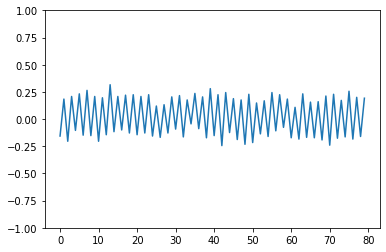

In [64]:
plt.plot(windowed_avg(rewards_21))
plt.ylim(-1, 1)

# 3. Deep Q-Learning
All of the following implementations will be based on the PyTorch RL Tutorial:  
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.htmlhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

We'll try to work on a GPU if one is available to PyTorch:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

## Network class

In [ ]:
class DQN(nn.Module):
    """
    state (3,3,2)->flatten->(18,) nn input
    """
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(18, 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 9)
    
    def forward(self, x):
        x = x.to(device)
        # Flattens x to make sure it can be passed to the linear layers
        x = self.flatten(x)
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        # No activation is a linear activation
        return self.output(x)

## Replay memory
This class is directly taken from the PyTorch DQN tutorial.

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQNPlayer class

In [ ]:
class DQNPlayer(Player):
    """
    Implements a type of Player that uses Deep Q-Learning
    to learn the tictactoe strategy.
    """
    def __init__(self, player='X', lr=5e-4, discount=0.99, epsilon=0.05, batch_size=64,
                  seed=666):
        super().__init__(player, epsilon, seed)
        self.lr = lr
        self.discount = discount
        self.epsilon = epsilon
        
        self.last_action, self.last_state = None, None
        
        # Neural networks
        self.policy_net = DQN().to(device)
        self.target_net = DQN().to(device)
        
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        
        # Huber loss
        self.criterion = nn.HuberLoss()
        # Adam optimizer
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.lr)
    
    def learn(self, reward, grid):
        """
        Stores the last (S, A, NS, R) tuple into the replay memory,
        and trains the policy network using a sample from the replay memory.
        --reward: float, end game reward
        --grid: (3, 3, 2) array representing the current state.
        Returns the value of the Huber loss.
        """
        # Push the last experience into the replay memory
        self.memory.push(self.last_state, self.last_action, grid, reward)
        
        # We don't start learning before the replay memory is large enough to
        # return at least a full batch
        if len(self.memory) < self.batch_size:
            return
        
        ## Policy network training ============================================
        # Taken from the Pytorch RL tutorial
        # First sample a batch of Transition objects
        transitions = self.memory.sample(self.batch_size)
        # Then creates a single Transition obj whose elements are arrays
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        
        # We need to know where in the batch the next state is final
        # as we can't compute max Q(ns, .) for those.
        # The final states are characterized by having the sum of the grid equal to 9
        # (1 for each cell).
        non_final_mask = next_state_batch.sum((1, 2, 3)) < 9
        non_final_next_states = next_state_batch[non_final_mask]
        
        # Computes the state-action values for all actions for all states in the batch
        state_action_values = self.policy_net(state_batch)
        # For each state, selects only Q(s, a) for the a which was actually chosen
        state_action_values = state_action_values.gather(1, action_batch)
        
        # We now need to compute max_a Q(s', a)
        next_state_qvalues = torch.zeros(self.batch_size, device=device)
        # We'll set it to zero for final states
        # Make sure to use the target network (not the policy) for training stability.
        # Note that tensor.max(dim=...) returns a namedtuple (values, indices)
        next_state_qvalues[non_final_mask] = self.target_net(non_final_next_states).max(dim=1).values
        # Detach the next state values from the gradient graph as it will be used
        # as the target in the computation of the loss (We consider it as the "true qvalue"
        # and hope to converge towards the Bellman equation).
        next_state_qvalues = next_state_qvalues.detach()
        
        # Final objective term
        target = reward_batch + self.discount * next_state_qvalues
        
        # Loss minimization using the optimizer (usual PyTorch training phase)
        self.optimizer.zero_grad()
        loss = self.criterion(state_action_values, target.unsqueeze(1))
        loss.backward()
        self.optimizer.step()
        # Returns the loss as a float value
        return loss.item()
    
    def update(self):
        """
        Udpates the target network by setting its weights
        to those of the policy network.
        """
        # We need to make a copy of the policy net's state_dict,
        # otherwise we'll keep updating the target net at each iteration
        state_dict = self.policy_net.state_dict()
        # Calling deepcopy() seems to be the "best" way:
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        self.target_net.load_state_dict(deepcopy(state_dict))
    
    def act(self, grid):
        """
        Chooses the action to perform by taking that which returns the
        best qvalue, as estimated by the policy network.
        Returns the action taken as an integer from 0 to 8.
        """
        # Check whether the epsilon-greedy choice activates
        if self.rng_.random() < self.epsilon:
            action = torch.tensor([[self.rng_.integers(0, 9)]], device=device)
        else:
            # We don't want those computations to impact the gradient graph
            # somehow
            with torch.no_grad():
                qvalues = self.policy_net(grid)
                # Select the action that has the highest qvalue
                # Note that tensor.max(dim=...) returns a namedtuple (values, indices)
                action = qvalues.max(dim=1).indices[0]
                # The action must have shape (1, 1) so that they can be concatenated
                # when sampled from the replay memory
                action = action.view(1, 1)
        
        self.last_state = grid
        self.last_action = action
        return int(action.item())
            
        

## Game function for DQN

In [ ]:
def grid33_to_332(grid, player, player2value):
    """
    Converts a grid in 3x3 shape whose values are -1, 0 and 1
    to the format expected by the DQN player, as a 3x3x2 array.
    --player: either 'X' or 'O', which player the DQN agent is.
    --player2value: player (X or O) to index (-1 or 1) association,
        obtained from the environment.
    """
    grid_332 = np.zeros((3, 3, 2))
    # Get the value in the original grid corresponding to the player
    # played by the dqn agent:
    player_ind = player2value[player]
    
    grid_332[grid == player_ind, 0] = 1
    grid_332[grid == -player_ind, 1] = 1
    return grid_332

In [ ]:
def play_games_dqn(dqn_player, benchmark_player, nb_games=20000,
                   games_between_updates=500,
                   turns_swap="switch",
                   seed=666):
    """
    Plays a given number of games between two players, and returns the rewards.
    --dqn_player: Instance of DQNPlayer to train;
    --benchmark_player: Player object implementing act();
    --nb_games: How many games should be played;
    --games_between_updates: how many games are played between two updates of the agent's
        target network.
    --turns_swap: str, either "switch" to switch turns after every game, or "random".
    --seed: random seed.
    Returns two arrays: rewards, losses
    """
    turns = np.array(['X','O'])
    dqn_player.set_player(turns[0])
    benchmark_player.set_player(turns[1])
    rewards, losses = [], []
    env = TictactoeEnv()
    
    for game in trange(nb_games):
        # Sets up the environment for the game
        env.reset()
        grid, _, _ = env.observe()
        # Convert the grid from the env's format to that expected by the agent
        grid_tensor = grid33_to_332(grid, dqn_player.player, env.player2value)
        grid_tensor = torch.tensor(grid_tensor, device=device).unsqueeze(0).float()
        
        if turns_swap == "switch":
            turns = turns[[-1, 0]]
        else:
            turns = np.random.shuffle(turns)
            
        dqn_player.set_player(turns[0])
        benchmark_player.set_player(turns[1])
        
        while True:
            # Action step
            # We now need to account for the case where the agent chooses
            # an unavailable position.
            if env.current_player == dqn_player.player:
                try:
                    move = dqn_player.act(grid_tensor)
                    grid, end, winner = env.step(move, print_grid=False)

                except ValueError:
                    # Stop the game and set the reward for the agent to -1
                    end = True
                    reward = -1
            else:
                move = benchmark_player.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                grid_tensor = grid33_to_332(grid, dqn_player.player, env.player2value)
                grid_tensor = torch.tensor(grid_tensor, device=device).unsqueeze(0).float()
                reward = env.reward(dqn_player.player)

                # Learning step
                # The DQN agent must have played at least once to start learning
                if dqn_player.last_action is not None:
                    losses.append(dqn_player.learn(torch.tensor([reward], device=device),
                                                   grid_tensor))

            if end:
                env.reset()
                rewards.append(reward)
                break
            
        # Update the agent's target network if required
        if game % games_between_updates == 0:
            dqn_player.update()
    
    return np.array(rewards), np.array(losses)

### 3.2 Learning from experts

In [ ]:
dqn_player = DQNPlayer(epsilon=0.05)
rewards, losses = play_games_dqn(dqn_player, semi_random_player)

In [ ]:
plt.plot(windowed_avg(rewards))
plt.ylim(-1, 1)

In [ ]:
plt.plot(losses)